In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras   
from data import Images_load

In [2]:
train, validation, test = Images_load.load_data()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1736/1736 [00:01<00:00, 1139.15it/s]


In [19]:
features, labels = train.features, train.labels
featuresV, labelsV = validation.features, validation.labels
featuresT, labelsT = test.features, test.labels

def stack_uneven(arrays, fill_value=0.):
    sizes = [a.shape for a in arrays]
    max_sizes = np.max(list(zip(*sizes)), -1)
    # The resultant array has stacked on the first dimension
    result = np.full((len(arrays),) + tuple(max_sizes), fill_value)
    for i, a in enumerate(arrays):
      # The shape of this array `a`, turned into slices
      slices = tuple(slice(0,s) for s in sizes[i])
      # Overwrite a block slice of `result` with this array `a`
      result[i][slices] = a
    return result

x_train = stack_uneven(features)
y_train = stack_uneven(labels)
y_test = stack_uneven(labelsT)
y_val = stack_uneven(labelsV)
x_test = stack_uneven(featuresT)

xtest = []

x_test = np.delete(x_test, 3, axis=3)
"""
for x in x_test:
    for y in x:
        for z in y:
            z = np.delete(z, 3)   
"""
print(x_test.shape)
x_test /= 225
x_train /= 225

(935, 65, 94, 3)


In [20]:
print(z)
x_train[200][0][0]
x_test[200][0][0]

[0. 0. 0.]


array([0.44888889, 0.54666667, 0.57333333])

In [21]:
#### Check the format of the data 
print ("train_im, train_lab types: ", type(x_train), type(y_train))
#### check the shape of the data
print ("shape of images and labels array: ", x_train.shape, y_train.shape) 
print ("shape of images and labels array ; test: ", x_test.shape, y_test.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (2103, 65, 94, 3) (2103, 2)
shape of images and labels array ; test:  (935, 65, 94, 3) (935, 2)


In [22]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(y_train, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[0.000e+00 2.103e+03]
 [1.000e+00 2.103e+03]]
2


In [23]:
print(y_train[0][0])

0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

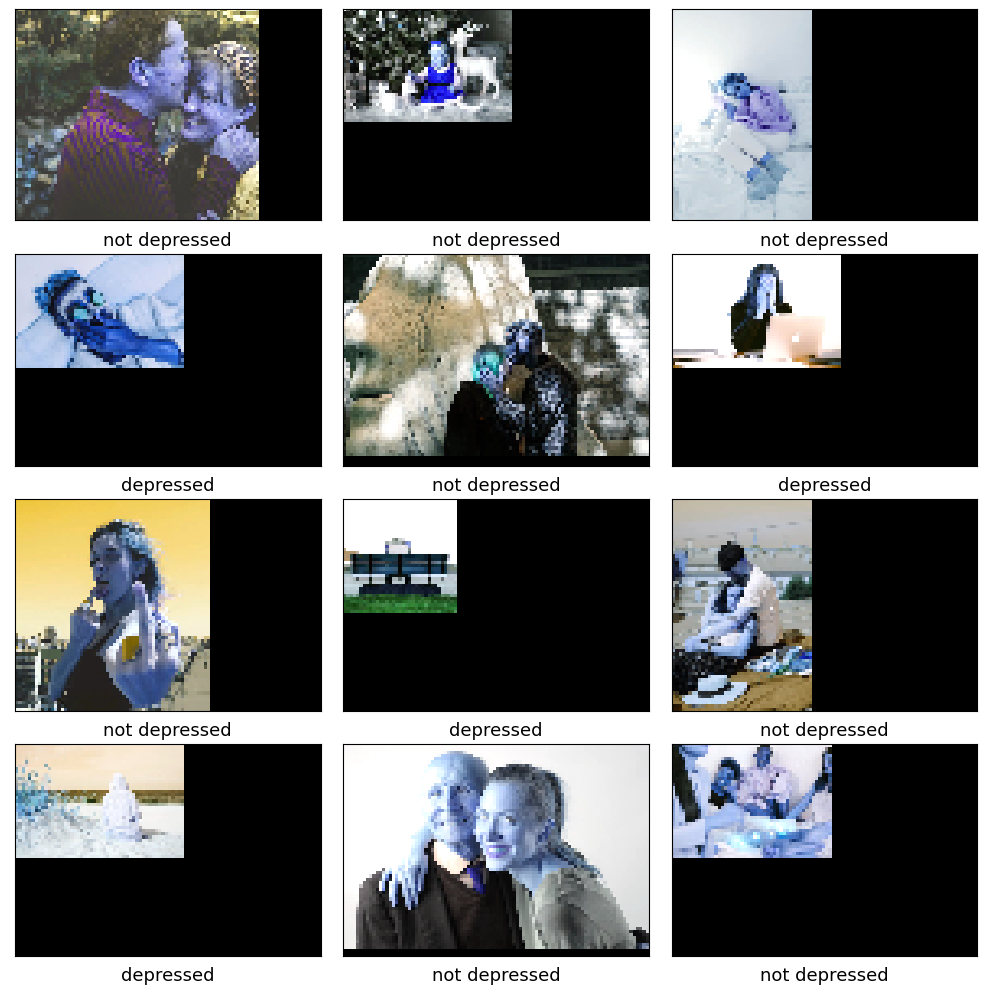

In [24]:
class_types = ['not depressed', 'depressed']
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    if(y_train[i][0] == 0.0):
        index = 0
    else:
        index = 1
    plt.xlabel(class_types[index], fontsize=13)
plt.tight_layout()    
plt.show()

In [25]:
train_lab_categorical = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='uint8')

print(train_lab_categorical[0])
print(y_train[0])

[[1 0]
 [0 1]]
[0. 1.]


In [26]:
x_test.shape

(935, 65, 94, 3)

In [27]:
from sklearn.model_selection import train_test_split 



train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, y_train.astype(int), test_size=0.20, 
                                                            stratify=y_train.astype(int), 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)


train data shape after the split:  (1682, 65, 94, 3)
new validation data shape:  (421, 65, 94, 3)
validation labels shape:  (421, 2)


In [28]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [29]:
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size)

In [30]:
def res_identity(x, filters): 
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [31]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [32]:

### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [33]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop 

In [34]:
resnet50_model = resnet50()

In [35]:

resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 94, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 71, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 33, 47, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 33, 47, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

 conv2d_10 (Conv2D)             (None, 16, 23, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 23, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 16, 23, 256)  0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 16, 23, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 8, 12, 512)   0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 12, 128)   65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 12, 128)  512         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 8, 12, 128)   0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 4, 6, 256)   1024        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 4, 6, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 6, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 4, 6, 256)   1024        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_42 (Conv2D)             (None, 4, 6, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 4, 6, 1024)  4096        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 4, 6, 1024)   0           ['batch_normalization_42[0][0]', 
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 4, 6, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 3, 2048)   0           ['batch_normalization_52[0][0]', 
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 3, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 2, 2048)  0           ['activation_48[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense (De

In [36]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

steps=train_im.shape[0]/64
val_steps=valid_im.shape[0]/64

print(steps)
print(val_steps)

26.28125
6.578125


In [37]:
batch_size=batch_size # test with 64, 128, 256

resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=5, 
                                  steps_per_epoch=2, 
                                  validation_steps=1, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])

Epoch 1/5
2/2 [==============================] - 18s 7s/step - loss: 22.4003 - acc: 0.5391 - val_loss: 18.7379 - val_acc: 0.4844 - lr: 0.0010
Epoch 2/5
2/2 [==============================] - 9s 5s/step - loss: 22.2514 - acc: 0.6250 - val_loss: 18.8951 - val_acc: 0.6562 - lr: 0.0010
Epoch 3/5
2/2 [==============================] - 9s 5s/step - loss: 19.2888 - acc: 0.6250 - val_loss: 18.8066 - val_acc: 0.5938 - lr: 0.0010
Epoch 4/5
2/2 [==============================] - 9s 5s/step - loss: 18.8017 - acc: 0.7812 - val_loss: 18.8388 - val_acc: 0.6094 - lr: 0.0010
Epoch 5/5
2/2 [==============================] - 9s 5s/step - loss: 18.6860 - acc: 0.8281 - val_loss: 18.9314 - val_acc: 0.7188 - lr: 0.0010


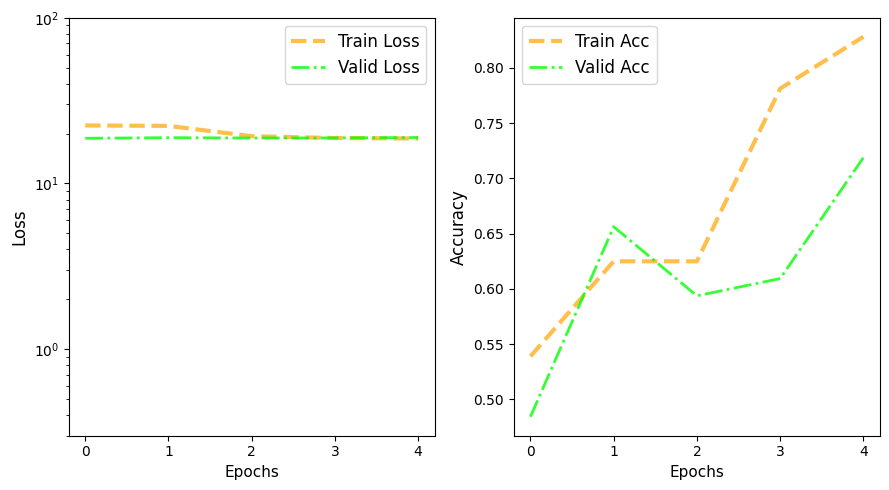

In [38]:
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
     

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    rounded_y_test = np.argmax(y_test, axis=1)
    cm=confusion_matrix(rounded_y_test, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(rounded_y_test,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()

30/30 [==============================] - 10s 287ms/step
Classification Report:

               precision    recall  f1-score   support

not depressed       0.53      0.14      0.22       416
    depressed       0.57      0.90      0.70       519

     accuracy                           0.56       935
    macro avg       0.55      0.52      0.46       935
 weighted avg       0.55      0.56      0.48       935



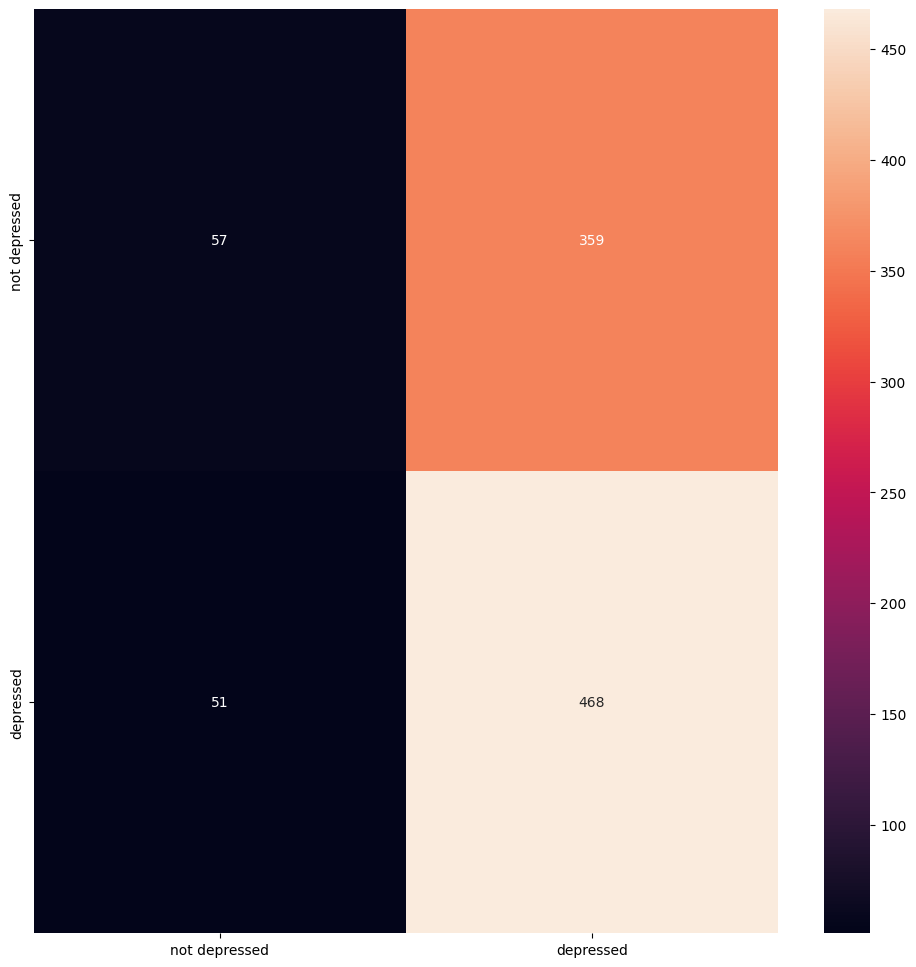

In [40]:
pred_class_resnet50 = resnet50_model.predict(x_test)

conf_matrix(pred_class_resnet50)

In [41]:
test_result = resnet50_model.evaluate(x_test, y_test, verbose=0)

print ("ResNet50 loss: ", test_result[0])
print ("ResNet50 accuracy: ", test_result[1])

ResNet50 loss:  18.918859481811523
ResNet50 accuracy:  0.5614973306655884
